### This notebook shows how to 

In [1]:
import os
from fabrictestbed.slice_manager import SliceManager, Status
import json

In [2]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

CM Host: cm.fabric-testbed.net Orchestrator Host: orchestrator.fabric-testbed.net


## Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [3]:
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, project_name='all', scope='all')

# Initialize the slice manager
slice_manager.initialize()

### Orchestrator API example to query for available resources

In [4]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 192/192 , ram: 1,536/1,536 G, disk: 60,600/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 9,600/9,600 G, unit: 10/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 381/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 304/320 , ram: 2,432/2,560 G, disk: 115,600/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 1/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 630/635 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
	Site Interfaces:
		TACC_UTAH: TrunkPort {

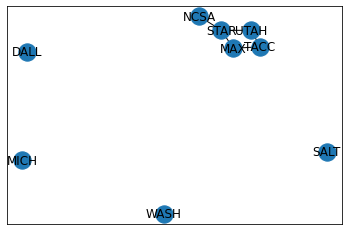

In [5]:
if status == Status.OK:
    advertised_topology.draw()

## Create Slice

We will request two nodes. We will attach a smart NIC to one of them, and a shared NIC to the other. Configurations for the NICs are going to be different.

The setup is shown below:

<img src="l2bridge-tagged-multiple-tags.png">

In [10]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
t = ExperimentTopology()

# Add node
n1 = t.add_node(name='n1', site='MAX')

# Set capacities
cap = Capacities()
cap.set_fields(core=2, ram=6, disk=10)

# Set Properties
n1.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add PCI devices
n1.add_component(ctype=ComponentType.NVME, model='P4510', name='c1')

# Add node
n2 = t.add_node(name='n2', site='MAX')

# Set properties
n2.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')

# Add node
n3 = t.add_node(name='n3', site='MAX')

# Set properties
n3.set_properties(capacities=cap, image_type='qcow2', image_ref='default_ubuntu_20')


n1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n1-nic1')
n2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_6, name='n2-nic1')
n3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name='n3-nic1')


interfaces_list = []
# For Tagged Bridge, specify VLAN
for i in t.interface_list:
#     print(i.name)
    include = False
    tag = ""
    if(i.name == 'n1-nic1-p1'):
        tag = "200"
    if(i.name == 'n2-nic1-p1'):
        tag = "200"
    if(i.name == 'n2-nic1-p2'):
        tag = "201"
    if(i.name == 'n3-nic1-p1'):
        tag = "201"
    if(i.name in ['n1-nic1-p1', 'n2-nic1-p1', 'n2-nic1-p2', 'n3-nic1-p1']):
        include = True
    if_labels = i.get_property(pname="labels")
    if_labels.vlan = tag
    i.set_properties(labels=if_labels)
    
    if(include):
        interfaces_list.append(i)

interfaces_tuple = tuple(interfaces_list)
    
# L2Bridge Service
t.add_network_service(name='bridge1', nstype=ServiceType.L2Bridge, interfaces=interfaces_tuple)

# Generate Slice Graph
slice_graph = t.serialize()

# print(interfaces_tuple)

ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read()
    ssh_key=ssh_key.strip()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name='Slice-l2bridge-ded-multiple-tags', slice_graph=slice_graph, ssh_key=ssh_key)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Reservations created {}".format(reservations))
else:
    print(f"Failure: {reservations}")

Response Status Status.OK
Reservations created [{
    "graph_node_id": "4bf3b4d4-3857-44b9-ac73-676eab56a20a",
    "lease_end": "2021-12-01 05:05:47",
    "pending_state": "None_",
    "reservation_id": "efeb3ddc-064a-4a17-ad6b-4b77c0a84e39",
    "reservation_state": "Unknown",
    "slice_id": "865a429f-f173-4488-a049-0125a956d970"
}, {
    "graph_node_id": "81dc7a6b-82ad-4a43-a00e-a462ac759c78",
    "lease_end": "2021-12-01 05:05:47",
    "pending_state": "None_",
    "reservation_id": "5d8e438e-ba36-4f21-bead-7c301667d9d2",
    "reservation_state": "Unknown",
    "slice_id": "865a429f-f173-4488-a049-0125a956d970"
}, {
    "graph_node_id": "d76d56ae-c5c3-42f6-9305-5f190b0dd259",
    "lease_end": "2021-12-01 05:05:47",
    "pending_state": "None_",
    "reservation_id": "696c2f14-f071-4f60-8ff0-25caa572b53d",
    "reservation_state": "Unknown",
    "slice_id": "865a429f-f173-4488-a049-0125a956d970"
}, {
    "graph_node_id": "95cd3e14-302c-4a24-adce-937da1b4d6f8",
    "lease_end": "2021

In [11]:
# Set the Slice ID from output of the above command
slice_id=reservations[0].slice_id

## Query Slices

In [15]:
status, slices = slice_manager.slices() #(state="All")

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slices {}".format(slices))
else:
    print(f"Failure: {slices}")

Response Status Status.OK
Slices [{
    "graph_id": "f1d68ad0-48ae-4f09-a051-369caed22446",
    "lease_end": "2021-11-21 01:22:55",
    "slice_id": "8ef39ae0-9ccd-40e8-992a-2497b01f5341",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "44625d85-ad4a-4c80-bb27-c3f810735c06",
    "lease_end": "2021-11-17 07:00:32",
    "slice_id": "7bb8c733-e0f8-4a0b-abaf-4b433ab66167",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "a161a769-0f89-43b0-bfe2-396c256baa25",
    "lease_end": "2021-11-22 19:23:09",
    "slice_id": "b4f605c8-6974-482d-a7fb-c0c6c3109108",
    "slice_name": "Slice-Kubernetes-Hello-World",
    "slice_state": "Dead"
}, {
    "graph_id": "df6b2c6f-e371-442b-a1f5-d18df4534e1d",
    "lease_end": "2021-12-01 05:03:24",
    "slice_id": "274f8cf0-976a-4d12-bf1d-44af0add4173",
    "slice_name": "Slice-l2bridge-ded-multiple-tags",
    "slice_state": "Closing"
}, {
    "graph_id": "90fa6b2a

## Query Slivers

In [16]:
slice_object = list(filter(lambda x: x.slice_id == slice_id, slices))[0]
status, slivers = slice_manager.slivers(slice_object=slice_object)

print("Response Status {}".format(status))
if status == Status.OK:
    print("Slivers {}".format(slivers))
else:
    print(f"Failure: {slivers}")

Response Status Status.OK
Slivers [{
    "graph_node_id": "95cd3e14-302c-4a24-adce-937da1b4d6f8",
    "join_state": "NoJoin",
    "lease_end": "2021-12-01 05:05:47",
    "name": "bridge1",
    "notices": "Reservation e711c826-a717-4517-88bc-8fb4dbc62e11 (Slice Slice-l2bridge-ded-multiple-tags(865a429f-f173-4488-a049-0125a956d970) Graph Id:90fa6b2a-6236-4a4b-a0b3-60bed34c97a2 Owner:name: orchestrator guid: orchestrator-guid email: minawm@bu.edu State:StableOK ) is in state [Active,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "pending_state": "None_",
    "reservation_id": "e711c826-a717-4517-88bc-8fb4dbc62e11",
    "reservation_state": "Active",
    "resource_type": "L2Bridge",
    "site": "MAX",
    "slice_id": "865a429f-f173-4488-a049-0125a956d970"
}, {
    "allocated_capacities": "{\"core\": 2, \"disk\": 10, \"ram\": 8}",
    "allocated_labels": "{\"instance\": \"instance-000006e1\", \"instance_parent\": \"max-w3.fabric-testbed.net\"}",

### Now let's connect to the nodes with paramiko.

In [17]:
import paramiko

In [20]:
client1_ip = list(filter(lambda sliver : sliver.name == "n1",slivers))[0].management_ip
client1_ip

'63.239.135.96'

In [21]:
client2_ip = list(filter(lambda sliver : sliver.name == "n2",slivers))[0].management_ip
client2_ip

'63.239.135.126'

In [22]:
client3_ip = list(filter(lambda sliver : sliver.name == "n3",slivers))[0].management_ip
client3_ip

'63.239.135.106'

In [23]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client1 = paramiko.SSHClient()
client1.load_system_host_keys()
client1.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client1.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client1.connect(client1_ip,username='ubuntu',pkey = key)

client1

In [24]:
stdin, stdout, stderr = client1.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [25]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client2 = paramiko.SSHClient()
client2.load_system_host_keys()
client2.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client2.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client2.connect(client2_ip,username='ubuntu',pkey = key)

client2

In [26]:
stdin, stdout, stderr = client2.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



In [27]:
key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client3 = paramiko.SSHClient()
client3.load_system_host_keys()
client3.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client3.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client3.connect(client3_ip,username='ubuntu',pkey = key)

client3

In [28]:
stdin, stdout, stderr = client3.exec_command('lsb_release -a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Distributor ID:	Ubuntu
Description:	Ubuntu 20.04.3 LTS
Release:	20.04
Codename:	focal

No LSB modules are available.



### Let's try to let the nodes ping each other through their management IPs.

In [29]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.126 (63.239.135.126) 56(84) bytes of data.
64 bytes from 63.239.135.126: icmp_seq=1 ttl=63 time=0.390 ms
64 bytes from 63.239.135.126: icmp_seq=2 ttl=63 time=0.273 ms
64 bytes from 63.239.135.126: icmp_seq=3 ttl=63 time=0.427 ms
64 bytes from 63.239.135.126: icmp_seq=4 ttl=63 time=0.342 ms
64 bytes from 63.239.135.126: icmp_seq=5 ttl=63 time=0.322 ms

--- 63.239.135.126 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4103ms
rtt min/avg/max/mdev = 0.273/0.350/0.427/0.053 ms




In [30]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.106 (63.239.135.106) 56(84) bytes of data.
64 bytes from 63.239.135.106: icmp_seq=1 ttl=63 time=0.356 ms
64 bytes from 63.239.135.106: icmp_seq=2 ttl=63 time=0.262 ms
64 bytes from 63.239.135.106: icmp_seq=3 ttl=63 time=0.358 ms
64 bytes from 63.239.135.106: icmp_seq=4 ttl=63 time=0.447 ms
64 bytes from 63.239.135.106: icmp_seq=5 ttl=63 time=0.325 ms

--- 63.239.135.106 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4076ms
rtt min/avg/max/mdev = 0.262/0.349/0.447/0.059 ms




In [31]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.96 (63.239.135.96) 56(84) bytes of data.
64 bytes from 63.239.135.96: icmp_seq=1 ttl=63 time=0.324 ms
64 bytes from 63.239.135.96: icmp_seq=2 ttl=63 time=0.329 ms
64 bytes from 63.239.135.96: icmp_seq=3 ttl=63 time=0.243 ms
64 bytes from 63.239.135.96: icmp_seq=4 ttl=63 time=0.250 ms
64 bytes from 63.239.135.96: icmp_seq=5 ttl=63 time=0.248 ms

--- 63.239.135.96 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4083ms
rtt min/avg/max/mdev = 0.243/0.278/0.329/0.039 ms




In [32]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 ' + client3_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.106 (63.239.135.106) 56(84) bytes of data.
64 bytes from 63.239.135.106: icmp_seq=1 ttl=63 time=0.314 ms
64 bytes from 63.239.135.106: icmp_seq=2 ttl=63 time=0.276 ms
64 bytes from 63.239.135.106: icmp_seq=3 ttl=63 time=0.343 ms
64 bytes from 63.239.135.106: icmp_seq=4 ttl=63 time=0.308 ms
64 bytes from 63.239.135.106: icmp_seq=5 ttl=63 time=0.307 ms

--- 63.239.135.106 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4076ms
rtt min/avg/max/mdev = 0.276/0.309/0.343/0.021 ms




In [33]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client1_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.96 (63.239.135.96) 56(84) bytes of data.
64 bytes from 63.239.135.96: icmp_seq=1 ttl=63 time=0.275 ms
64 bytes from 63.239.135.96: icmp_seq=2 ttl=63 time=0.193 ms
64 bytes from 63.239.135.96: icmp_seq=3 ttl=63 time=0.205 ms
64 bytes from 63.239.135.96: icmp_seq=4 ttl=63 time=0.276 ms
64 bytes from 63.239.135.96: icmp_seq=5 ttl=63 time=0.228 ms

--- 63.239.135.96 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4079ms
rtt min/avg/max/mdev = 0.193/0.235/0.276/0.034 ms




In [34]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 ' + client2_ip)
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 63.239.135.126 (63.239.135.126) 56(84) bytes of data.
64 bytes from 63.239.135.126: icmp_seq=1 ttl=63 time=0.353 ms
64 bytes from 63.239.135.126: icmp_seq=2 ttl=63 time=0.349 ms
64 bytes from 63.239.135.126: icmp_seq=3 ttl=63 time=0.265 ms
64 bytes from 63.239.135.126: icmp_seq=4 ttl=63 time=0.256 ms
64 bytes from 63.239.135.126: icmp_seq=5 ttl=63 time=0.294 ms

--- 63.239.135.126 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4088ms
rtt min/avg/max/mdev = 0.256/0.303/0.353/0.040 ms




### We can see that the nodes are able to ping each other. This should be made possible by the control plane.

### We want to let the nodes communicate through the bridge that we have requested.

### To begin with, we will need to use the `route` command. So we need to install `net-tools`.

In [35]:
stdin, stdout, stderr = client1.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt update && sudo apt install net-tools')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Hit:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1058 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 Packages [8628 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main Translation-en [195 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [9072 B]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [559 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted Translation-en [80.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [528 B]
Get:12 http://security.ubuntu.com/ubuntu focal-security/unive

### Let's also install traceroute

In [36]:
stdin, stdout, stderr = client1.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt install traceroute')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  traceroute
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 45.4 kB of archives.
After this operation, 152 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 traceroute amd64 1:2.1.0-2 [45.4 kB]
Fetched 45.4 kB in 0s (147 kB/s)
Selecting previously unselected package traceroute.
(Reading database ... 63561 files and directories currently installed.)
Preparing to unpack .../traceroute_1%3a2.1.0-2_amd64.deb ...
Unpacking traceroute (1:2.1.0-2) ...
Setting up traceroute (1:2.1.0-2) ...
update-alternatives: using /usr/bin/traceroute.db to provide /usr/bin/traceroute (traceroute) in auto mode
update-alternatives: using /usr/bin/lft.db to provide /usr/bin/lft (lft) in auto mode
update-alternatives: using /usr/bin/traceproto.db to provide /usr/bin/traceproto (traceproto) in au

### Let's look at the available interfaces.

In [37]:
stdin, stdout, stderr = client1.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:bd:08:d0 brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.215/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86093sec preferred_lft 86093sec
    inet6 fe80::f816:3eff:febd:8d0/64 scope link 
       valid_lft forever preferred_lft forever
3: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:a6:70 brd ff:ff:ff:ff:ff:ff
4: ens9: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:a6:71 brd ff:ff:ff:ff:ff:ff




In [38]:
stdin, stdout, stderr = client2.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:c0:52:9a brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.137/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86090sec preferred_lft 86090sec
    inet6 fe80::f816:3eff:fec0:529a/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:9f:e0 brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fe:9f:e1 brd ff:ff:ff:ff:ff:ff




In [39]:
stdin, stdout, stderr = client3.exec_command('ip a')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

1: lo: <LOOPBACK,UP,LOWER_UP> mtu 65536 qdisc noqueue state UNKNOWN group default qlen 1000
    link/loopback 00:00:00:00:00:00 brd 00:00:00:00:00:00
    inet 127.0.0.1/8 scope host lo
       valid_lft forever preferred_lft forever
    inet6 ::1/128 scope host 
       valid_lft forever preferred_lft forever
2: ens3: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc fq_codel state UP group default qlen 1000
    link/ether fa:16:3e:c7:39:0c brd ff:ff:ff:ff:ff:ff
    inet 10.20.4.119/24 brd 10.20.4.255 scope global dynamic ens3
       valid_lft 86089sec preferred_lft 86089sec
    inet6 fe80::f816:3eff:fec7:390c/64 scope link 
       valid_lft forever preferred_lft forever
3: ens7: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fa:75:5c brd ff:ff:ff:ff:ff:ff
4: ens8: <BROADCAST,MULTICAST> mtu 1500 qdisc noop state DOWN group default qlen 1000
    link/ether 04:3f:72:fa:75:5d brd ff:ff:ff:ff:ff:ff




### All nodes have two network interfaces.

### Now, we need to remember that we have requested that

- `n1`'s first port (`ens8`) and `n2`'s first port (`ens7`) are in the same vlan which is tagged `200`
- `n2`'s second port (`ens8`) and `n3`'s first port (`ens7`) are in the same vlan which is tagged `201`

<hr>

### Now let's configure our interfaces.

### Let's begin by configuring `n1`'s NIC.

In [40]:
stdin, stdout, stderr = client1.exec_command('sudo ip link add link ens8 name ens8.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [41]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [42]:
stdin, stdout, stderr = client1.exec_command('sudo ip link set dev ens8.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [43]:
stdin, stdout, stderr = client1.exec_command('sudo ip addr add 192.168.10.51/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's configure `n2`'s NIC.

<!-- ### We need to add a new interface that picks traffic tagged `200` (as we specified when we were creating the slice).

### We are going to create two "vlan" interfaces called `ens7.200` and `ens8.200`. They are going to pick traffic tagged `200` from their corresponding interfaces (`ens7` and `ens8` respectively).

### And then we will assign IP addresses to `ens7.200` and `ens8.200`. -->

In [44]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens7 name ens7.200 type vlan id 200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [45]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [46]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens7.200 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [47]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.10.52/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

In [48]:
stdin, stdout, stderr = client2.exec_command('sudo ip link add link ens8 name ens8.201 type vlan id 201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [49]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [50]:
stdin, stdout, stderr = client2.exec_command('sudo ip link set dev ens8.201 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [51]:
stdin, stdout, stderr = client2.exec_command('sudo ip addr add 192.168.20.52/24 dev ens8.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### And finally, let's configure `n3`'s NICs.

In [52]:
stdin, stdout, stderr = client3.exec_command('sudo ip link add link ens7 name ens7.201 type vlan id 201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [53]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [54]:
stdin, stdout, stderr = client3.exec_command('sudo ip link set dev ens7.201 up')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [55]:
stdin, stdout, stderr = client3.exec_command('sudo ip addr add 192.168.20.53/24 dev ens7.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### Next thing to do is add routes.
<!-- 
### For `n1`, we are going to direct traffic going to both `192.168.11.0` and `192.168.12.0` through `ens8` -->

### For `n1`

In [56]:
stdin, stdout, stderr = client1.exec_command('sudo route add -net 192.168.10.0/24 dev ens8.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### For `n2`

<!-- we are going to direct traffic going to `192.168.10.0` through `ens7.200`. -->

In [57]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.10.0/24 dev ens7.200')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [58]:
stdin, stdout, stderr = client2.exec_command('sudo route add -net 192.168.20.0/24 dev ens8.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

### For `n3`

In [59]:
stdin, stdout, stderr = client3.exec_command('sudo route add -net 192.168.20.0/24 dev ens7.201')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

<hr>

### Now let's ping

In [60]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.235 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.063 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.064 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.063 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.060 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4100ms
rtt min/avg/max/mdev = 0.060/0.097/0.235/0.069 ms




In [61]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4088ms





In [62]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4093ms





### We can see above that client1 is able to talk to client2's first port only.

In [63]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.111 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.054 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.057 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.052 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.061 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4094ms
rtt min/avg/max/mdev = 0.052/0.067/0.111/0.022 ms




In [64]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=0.297 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=0.079 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=0.056 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=0.137 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=0.138 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4078ms
rtt min/avg/max/mdev = 0.056/0.141/0.297/0.084 ms




### We can see above that client2 can talk to client1's port and client3's port.

In [65]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.174 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.056 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.052 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.050 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.061 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4077ms
rtt min/avg/max/mdev = 0.050/0.078/0.174/0.047 ms




In [66]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4087ms





In [67]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 0 received, 100% packet loss, time 4093ms





### We can see above that client3 can only talk to client2's second port.

<hr>

### Next, we'll let node 2 act as a router between nodes 1 and 3. This will let nodes 1 and 3 be able to reach each other through node 2.

### We need to:
- let nodes 1 and 3 route packets through the interfaces of the ports that we've already configured.
- let node 2 forward packets.

In [68]:
stdin, stdout, stderr = client1.exec_command('sudo ip route add 192.168.20.0/24 via 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [69]:
stdin, stdout, stderr = client3.exec_command('sudo ip route add 192.168.10.0/24 via 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

In [70]:
stdin, stdout, stderr = client2.exec_command('sudo sysctl -w net.ipv4.ip_forward=1')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

net.ipv4.ip_forward = 1




<hr>

### Now let's ping again.

In [71]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.123 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.073 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.059 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.146 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.094 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4089ms
rtt min/avg/max/mdev = 0.059/0.099/0.146/0.031 ms




In [72]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.109 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.070 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.063 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.059 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.064 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4074ms
rtt min/avg/max/mdev = 0.059/0.073/0.109/0.018 ms




In [73]:
stdin, stdout, stderr = client1.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=63 time=0.212 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=63 time=0.113 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=63 time=0.117 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=63 time=0.127 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=63 time=0.132 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4077ms
rtt min/avg/max/mdev = 0.113/0.140/0.212/0.036 ms




### We can see that all network interfaces are now reachable.

### Now let's do a traceroute to see the path that the packets take.

In [74]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  0.152 ms  0.096 ms  0.089 ms




In [75]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.085 ms * *




In [76]:
stdin, stdout, stderr = client1.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  0.097 ms  0.110 ms *
 2  192.168.20.53 (192.168.20.53)  0.239 ms  0.201 ms *




### We can see that the two ports of client 2 are directly reachable, as if they are directly connected.

### And we can see that client 3 is reachable after one hop through client 2.

### Now let's look at the rest of the clients.

In [77]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=64 time=0.192 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=64 time=0.072 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=64 time=0.048 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=64 time=0.057 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=64 time=0.055 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4102ms
rtt min/avg/max/mdev = 0.048/0.084/0.192/0.054 ms




In [78]:
stdin, stdout, stderr = client2.exec_command('ping -c 5 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.53 (192.168.20.53) 56(84) bytes of data.
64 bytes from 192.168.20.53: icmp_seq=1 ttl=64 time=0.123 ms
64 bytes from 192.168.20.53: icmp_seq=2 ttl=64 time=0.080 ms
64 bytes from 192.168.20.53: icmp_seq=3 ttl=64 time=0.092 ms
64 bytes from 192.168.20.53: icmp_seq=4 ttl=64 time=0.092 ms
64 bytes from 192.168.20.53: icmp_seq=5 ttl=64 time=0.082 ms

--- 192.168.20.53 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4076ms
rtt min/avg/max/mdev = 0.080/0.093/0.123/0.015 ms




<hr>

In [79]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.10.51 (192.168.10.51)  0.077 ms  0.061 ms  0.048 ms




In [80]:
stdin, stdout, stderr = client2.exec_command('traceroute 192.168.20.53')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.53 (192.168.20.53), 30 hops max, 60 byte packets
 1  * 192.168.20.53 (192.168.20.53)  0.254 ms  0.282 ms




<hr>

In [81]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.20.52 (192.168.20.52) 56(84) bytes of data.
64 bytes from 192.168.20.52: icmp_seq=1 ttl=64 time=0.056 ms
64 bytes from 192.168.20.52: icmp_seq=2 ttl=64 time=0.077 ms
64 bytes from 192.168.20.52: icmp_seq=3 ttl=64 time=0.081 ms
64 bytes from 192.168.20.52: icmp_seq=4 ttl=64 time=0.060 ms
64 bytes from 192.168.20.52: icmp_seq=5 ttl=64 time=0.064 ms

--- 192.168.20.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4075ms
rtt min/avg/max/mdev = 0.056/0.067/0.081/0.009 ms




In [82]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.52 (192.168.10.52) 56(84) bytes of data.
64 bytes from 192.168.10.52: icmp_seq=1 ttl=64 time=0.077 ms
64 bytes from 192.168.10.52: icmp_seq=2 ttl=64 time=0.071 ms
64 bytes from 192.168.10.52: icmp_seq=3 ttl=64 time=0.058 ms
64 bytes from 192.168.10.52: icmp_seq=4 ttl=64 time=0.051 ms
64 bytes from 192.168.10.52: icmp_seq=5 ttl=64 time=0.073 ms

--- 192.168.10.52 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4087ms
rtt min/avg/max/mdev = 0.051/0.066/0.077/0.009 ms




In [83]:
stdin, stdout, stderr = client3.exec_command('ping -c 5 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

PING 192.168.10.51 (192.168.10.51) 56(84) bytes of data.
64 bytes from 192.168.10.51: icmp_seq=1 ttl=63 time=0.114 ms
64 bytes from 192.168.10.51: icmp_seq=2 ttl=63 time=0.111 ms
64 bytes from 192.168.10.51: icmp_seq=3 ttl=63 time=0.113 ms
64 bytes from 192.168.10.51: icmp_seq=4 ttl=63 time=0.116 ms
64 bytes from 192.168.10.51: icmp_seq=5 ttl=63 time=0.115 ms

--- 192.168.10.51 ping statistics ---
5 packets transmitted, 5 received, 0% packet loss, time 4077ms
rtt min/avg/max/mdev = 0.111/0.113/0.116/0.001 ms




In [84]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.20.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.20.52 (192.168.20.52), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.059 ms  0.059 ms  0.061 ms




In [87]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.52')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.52 (192.168.10.52), 30 hops max, 60 byte packets
 1  192.168.10.52 (192.168.10.52)  0.131 ms  0.107 ms  0.094 ms




In [89]:
stdin, stdout, stderr = client3.exec_command('traceroute 192.168.10.51')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

traceroute to 192.168.10.51 (192.168.10.51), 30 hops max, 60 byte packets
 1  192.168.20.52 (192.168.20.52)  0.074 ms  0.053 ms *
 2  192.168.10.51 (192.168.10.51)  0.106 ms  0.093 ms *




<hr>

### Now let's do a bandwidth test between client 1 and client 3 (through the router). First we install iperf3.

In [97]:
stdin, stdout, stderr = client1.exec_command('sudo apt install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client2.exec_command('sudo apt install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))
stdin, stdout, stderr = client3.exec_command('sudo apt install -y iperf3')
print(stdout.read().decode("utf-8"))
print(stderr.read().decode("utf-8"))

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libiperf0 libsctp1
Suggested packages:
  lksctp-tools
The following NEW packages will be installed:
  iperf3 libiperf0 libsctp1
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 94.1 kB of archives.
After this operation, 331 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 libsctp1 amd64 1.0.18+dfsg-1 [7876 B]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 libiperf0 amd64 3.7-3 [72.0 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 iperf3 amd64 3.7-3 [14.2 kB]
Fetched 94.1 kB in 0s (1112 kB/s)
Selecting previously unselected package libsctp1:amd64.
(Reading database ... 94636 files and directories currently installed.)
Preparing to unpack .../libsctp1_1.0.18+dfsg-1_amd64.deb ...
Unpacking libsctp1:amd64 (1.0.18+dfs

### Then we can use the code module below.

In [101]:
def bandwidth_test(clientn1, clientn2, ip_of_interface_on_n1, ip_of_interface_on_n2, verbose):
    output = "Information about bandwidth with iperf: \n"
    stdin, stdout, stderr = clientn1.exec_command('echo "net.core.rmem_max = 2147483647\nnet.core.wmem_max = 2147483647\nnet.ipv4.tcp_rmem = 4096 87380 2147483647\nnet.ipv4.tcp_wmem = 4096 65536 2147483647\nnet.ipv4.tcp_congestion_control=htcp\nnet.ipv4.tcp_mtu_probing=1\nnet.core.default_qdisc = fq\n" | sudo tee -a /etc/sysctl.conf && sudo sysctl -p')
    stdin, stdout, stderr = clientn2.exec_command('echo "net.core.rmem_max = 2147483647\nnet.core.wmem_max = 2147483647\nnet.ipv4.tcp_rmem = 4096 87380 2147483647\nnet.ipv4.tcp_wmem = 4096 65536 2147483647\nnet.ipv4.tcp_congestion_control=htcp\nnet.ipv4.tcp_mtu_probing=1\nnet.core.default_qdisc = fq\n" | sudo tee -a /etc/sysctl.conf && sudo sysctl -p')
    stdin, stdout, stderr = clientn1.exec_command('iperf3 -s > /dev/null 2>&1 &')
    stdin, stdout, stderr = clientn2.exec_command('iperf3 -s > /dev/null 2>&1 &')
    stdin, stdout, stderr = clientn2.exec_command('iperf3 -c ' + ip_of_interface_on_n1 + ' -P 32 -w 512M -R')
    iperf_string = stdout.read().decode("utf-8")
    output += "n2 to n1:\n"
    iperf_strings = iperf_string.splitlines()
    if(len(iperf_strings) > 3):
        output += iperf_string.splitlines()[-4] + "\n"
        output += iperf_string.splitlines()[-3] + "\n"
    stdin, stdout, stderr = clientn1.exec_command('iperf3 -c ' + ip_of_interface_on_n2 + ' -P 32 -w 512M -R')
    iperf_string = stdout.read().decode("utf-8")
    # iperf_string2 = re.findall("^(.*)\n^(.*)\n^(.*)\n^(.*)$\z", iperf_string)
    output += "n1 to n2:\n"
    iperf_strings = iperf_string.splitlines()
    if(len(iperf_strings) > 3):
        output += iperf_string.splitlines()[-4] + "\n"
        output += iperf_string.splitlines()[-3]
        
    return {"Bandwidth" : output}

In [105]:
bandwidth_test(client1, client3, "192.168.10.51", "192.168.20.53", False)

{'Bandwidth': 'Information about bandwidth with iperf: \nn2 to n1:\n[SUM]   0.00-10.00  sec  12.6 GBytes  10.8 Gbits/sec  305990             sender\n[SUM]   0.00-10.00  sec  11.7 GBytes  10.0 Gbits/sec                  receiver\nn1 to n2:\n[SUM]   0.00-10.00  sec  11.6 GBytes  9.95 Gbits/sec  268165             sender\n[SUM]   0.00-10.00  sec  10.4 GBytes  8.96 Gbits/sec                  receiver'}